# TF-IDF in digitised journals

This notebook calculates TF-IDF values for words in digitised journals harvested from Trove. See also the notebook on [word frequences in digitised journals](word_frequences_in_digitised_journals.ipynb). More documentation coming...

In [11]:
import re
import tarfile
import zipfile
from io import BytesIO
import pandas as pd
import requests
from tqdm.auto import tqdm
import altair as alt
import os
from pathlib import Path
import ipywidgets as widgets
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np

In [12]:
# Are you using Jupyter Lab?
# If so either don't run this cell or comment out the line below

alt.renderers.enable('notebook')

# If you forget, run this cell, and then get strange warnings when you make a chart,
# uncomment the following line and run this cell to reset the chart renderer

# alt.renderers.enable('default')

RendererRegistry.enable('notebook')

## Select a journal

Create a dropdown widget to select a digitised journal. The cells below will use this widget to get the value of the currently selected journal.

In [2]:
# Load details of digitised journals from CSV
df_journals = pd.read_csv('digital-journals-with-text.csv').sort_values(by='title')
journal_list = [(f"{j['title']} ({j['issues_with_text']} issues)", j['directory']) for j in df_journals[['title', 'directory', 'issues_with_text']].to_dict('records')]
journals = widgets.Dropdown(options=journal_list, disabled=False)
display(journals)

Dropdown(options=(('"Coo-ee!" (Bishops Knoll Hospital (Bristol, England)) (12 issues)', 'coo-ee-bishops-knoll-…

## Download all the issues of the journal

Download a zip file containing the OCRd text of all the selected journal's available issues from the repository on CloudStor. Then unzip!

In [3]:
def get_docs_path(journal):
    path = os.path.join('downloads', journal, 'texts')
    docs_path = [p for p in sorted(Path(path).glob('*.txt'))]
    return docs_path

def download_journal(journal):
    '''
    Download the OCRd text of the selected journal from the respoitory on CloudStor. 
    '''
    
    # Create a directory to put the downloaded files
    path = os.path.join('downloads', journal)
    os.makedirs(path, exist_ok=True)
    
    # To get a sub-folder on Cloudstor you add a 'path' parameter
    params = {
        'path': f'/{journal}/texts'
    }
    
    # Get the zipped texts folder from Cloudstor -- note the 'download' in the url to get the zipped folder
    response = requests.get('https://cloudstor.aarnet.edu.au/plus/s/QOmnqpGQCNCSC2h/download', params=params)
    
    # Unzip the zip!
    zipped = zipfile.ZipFile(BytesIO(response.content))
    zipped.extractall(path)
    
    print(f'{len(get_docs_path(journal))} issues downloaded')

In [4]:
# Get the OCRd text of the selected journal
download_journal(journals.value)

102 issues downloaded


## Calculate the TF-IDF values

In [13]:
def get_docs(journal):
    docs_path = get_docs_path(journal)
    for p in docs_path:
        yield p.read_text(encoding='utf-8').strip()

def get_file_names(journal):
    return [p.stem for p in get_docs_path(journal)]

def get_years(journal):
    '''
    Get a list of years extracted from the filenames of the issues.
    '''
    years = []
    for doc in get_docs_path(journal):
        try:
            matches = re.findall(r'-((?:18|19|20)\d{2})-', doc.stem)
            years.append(int(matches[-1]))
        except IndexError:
            print(f'YEAR NOT FOUND: {doc}')
    return sorted(list(set(years)))

def get_docs_year(journal):
    '''
    Combine all the issues from a year into a single document ready to be fed into the pipeline.
    '''
    docs_year = {}
    path = Path(f'{journals}/texts')
    for doc in get_docs_path(journal):
        try:
            matches = re.findall(r'-((?:18|19|20)\d{2})-', doc.stem)
            year = int(matches[-1])
        except IndexError:
            print(f'YEAR NOT FOUND: {doc}')
        else:
            try:
                docs_year[year].append(doc)
            except KeyError:
                docs_year[year] = [doc]
    for y in sorted(docs_year.keys()):
        year_doc = ' '.join([p.read_text(encoding='utf-8').strip() for p in docs_year[y]])
        yield year_doc

Calculate the TF-IDF values for each year.

In [14]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000, ngram_range=(1,1), min_df=5, max_df=0.5)
# preprocessor = lambda x: re.sub(r'(\d[\d\.])+', 'NUM', x.lower())
X_freq = np.asarray(vectorizer.fit_transform(get_docs_year(journals.value)).todense())
df_tfidf_years = pd.DataFrame(X_freq, columns=vectorizer.get_feature_names(), index=get_years(journals.value))

In [15]:
# Save as a CSV
#df_freq.to_csv(f'{journals.value}-word-frequencies.csv')

In [16]:
# Display the results
df_tfidf_years.head()

,00,03,101,102,103,104,105,107,110,1107,...,zealanders,zelman,zenith,zest,zinc,zone,zontal,zoo,zora,zorn
1916,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.00000,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000
1917,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.019559,0.0,0.00000,0.000000,0.035180,0.00000,0.0,0.0,0.020737,0.000000
1918,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.019348,0.0,0.00000,0.000000,0.000000,0.00000,0.0,0.0,0.041028,0.000000
1919,0.0,0.012404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.00000,0.008574,0.000000,0.02328,0.0,0.0,0.000000,0.000000
1921,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.02155,0.013330,0.015351,0.00000,0.0,0.0,0.012065,0.043099


Let's display the words each year with the highest TF-IDF scores.

In [17]:
# Top words per year
df_years_top = pd.DataFrame({n: df_tfidf_years.T[col].nlargest(10).index.tolist() for n, col in enumerate(df_tfidf_years.T)}).T
df_years_top.index = get_years(journals.value)
df_years_top.head()

,0,1,2,3,4,5,6,7,8,9
1916,rodway,beckwith,theological,bitten,caves,malady,villon,plough,aquatints,morocco
1917,baldwin,cobb,dennis,williams,berger,optical,verses,1917,paterson,handy
1918,connell,raalte,hayley,lever,macnally,sid,6d,cumbrae,weston,olsson
1919,raeburn,rix,munnings,wilkie,nicholas,paterson,clewin,wahroonga,cumbrae,harcourt
1921,greenway,convicts,baxter,regiment,excellency,kodak,sims,haden,aquatint,barracks


And know we'll display the results in one huuuge chart.

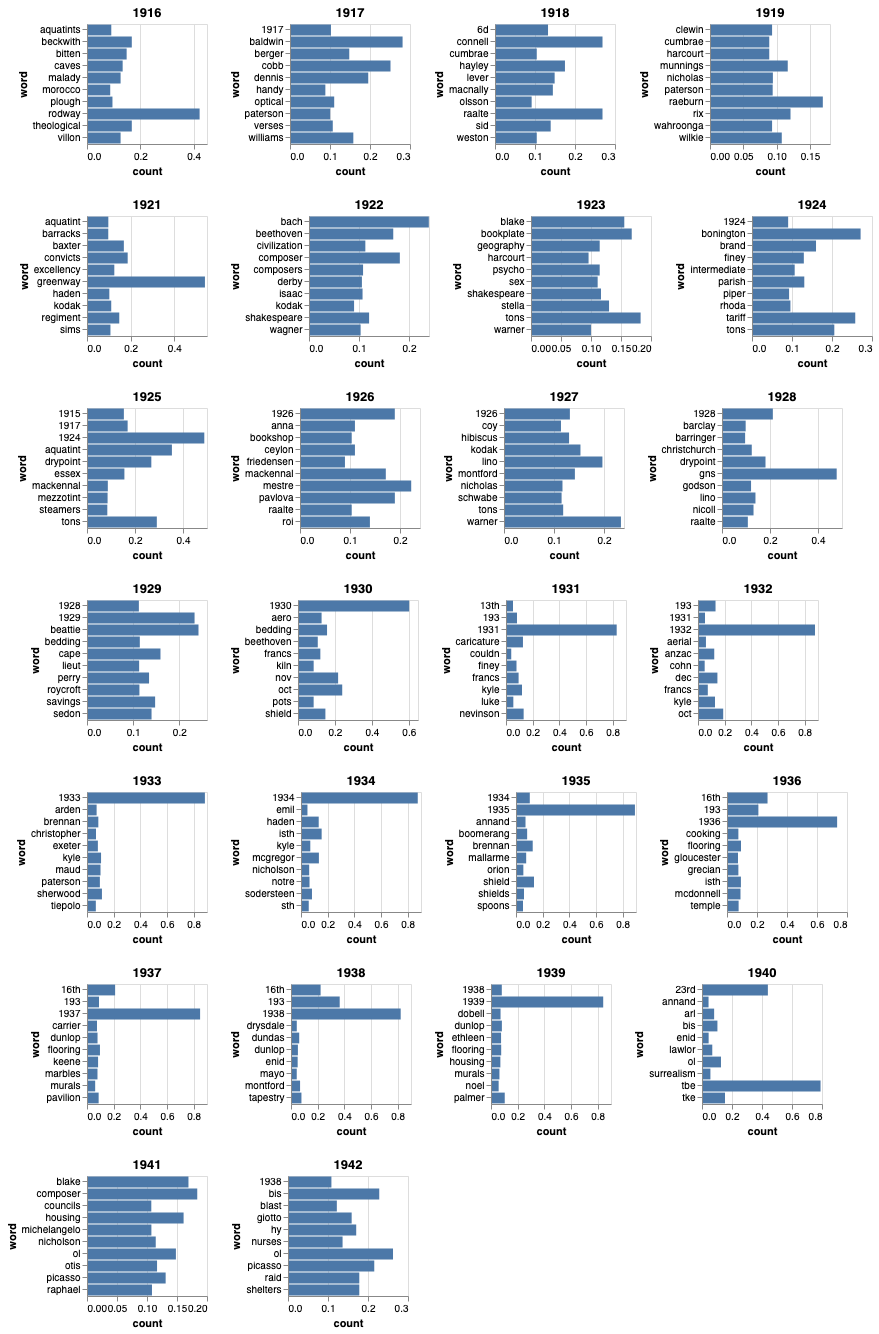

In [18]:
compound_chart = alt.vconcat()
years = get_years(journals.value)
# Number of columns
cols = 4
start = 0
while start < len(years):
    row = alt.hconcat()
    for year in years[start:start+cols]:
        df_year_word_count = pd.DataFrame([{'word': w, 'count': df_tfidf_years.loc[year][w]} for w in df_years_top.loc[year].tolist()])
        chart = alt.Chart(df_year_word_count).mark_bar().encode(
            y='word:N',
            x='count:Q',
        ).properties(width=120, height=120, title=str(year), columns=4)
        row |= chart
    compound_chart &= row
    start += cols
compound_chart